# Test resnet_small_48x48.keras on validation images
This notebook loads the model in `models/resnet_small_48x48.keras`, runs it on the images under `Data/Maheshi/processed_images/validation`, computes accuracy and a confusion matrix, and saves per-image predictions to CSV.

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

# Paths (relative to this notebook)
MODEL_PATH = Path('../../models/resnet_small_48x48.keras')
VAL_DIR = Path('../../Data/Maheshi/processed_images/validation')
OUT_CSV = Path('resnet_validation_predictions.csv')

# Model input size
IMG_SIZE = (48, 48)

In [2]:
# Load model
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")
model = tf.keras.models.load_model(str(MODEL_PATH))
print('Loaded model:', MODEL_PATH)

Loaded model: ..\..\models\resnet_small_48x48.keras


In [3]:
# Gather validation images and labels
if not VAL_DIR.exists():
    raise FileNotFoundError(f"Validation folder not found: {VAL_DIR}")
class_dirs = [p for p in sorted(VAL_DIR.iterdir()) if p.is_dir()]
if not class_dirs:
    raise RuntimeError(f"No class subfolders found in {VAL_DIR}")
class_names = [p.name for p in class_dirs]
class_to_idx = {name:i for i,name in enumerate(class_names)}
print('Classes:', class_names)

image_paths = []
labels = []
for cdir in class_dirs:
    for img_path in sorted(cdir.iterdir()):
        if img_path.is_file():
            image_paths.append(img_path)
            labels.append(class_to_idx[cdir.name])

n = len(image_paths)
print(f'Found {n} validation images')

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7062 validation images
Found 7062 validation images


In [4]:
# Read and preprocess images into a single array (may use memory)
X = np.zeros((n, IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32)
y = np.array(labels, dtype=np.int32)
for i,p in enumerate(image_paths):
    img = cv2.imread(str(p))
    if img is None:
        raise RuntimeError(f'Unable to read image: {p}')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img
    resized = cv2.resize(gray, IMG_SIZE)
    X[i,:,:,0] = resized.astype('float32') / 255.0

print('Prepared arrays:', X.shape, y.shape)

Prepared arrays: (7062, 48, 48, 1) (7062,)


In [5]:
# Run predictions in batches to avoid memory spikes
batch = 64
preds = model.predict(X, batch_size=batch)
y_pred = np.argmax(preds, axis=1)
confidences = np.max(preds, axis=1)

# Compute accuracy
accuracy = (y_pred == y).mean()
print(f'Accuracy: {accuracy:.4f} ({(accuracy*100):.2f}%)')

# Confusion matrix (numpy implementation)
num_classes = len(class_names)
confusion = np.zeros((num_classes, num_classes), dtype=np.int32)
for t,p in zip(y, y_pred):
    confusion[t, p] += 1

print('Confusion matrix:')
print(confusion)

111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step
Accuracy: 0.6672 (66.72%)
Confusion matrix:
[[ 561    9   84   32  106  136   29]
 [   7   98    2    1    3    0    0]
 [ 135    3  412   33   94  213  128]
 [  49    0   29 1520   99   64   64]
 [  70    3   59   68  839  149   28]
 [ 118    6  117   28  242  607   20]
 [  19    2   47   25   19   10  675]]
Accuracy: 0.6672 (66.72%)
Confusion matrix:
[[ 561    9   84   32  106  136   29]
 [   7   98    2    1    3    0    0]
 [ 135    3  412   33   94  213  128]
 [  49    0   29 1520   99   64   64]
 [  70    3   59   68  839  149   28]
 [ 118    6  117   28  242  607   20]
 [  19    2   47   25   19   10  675]]


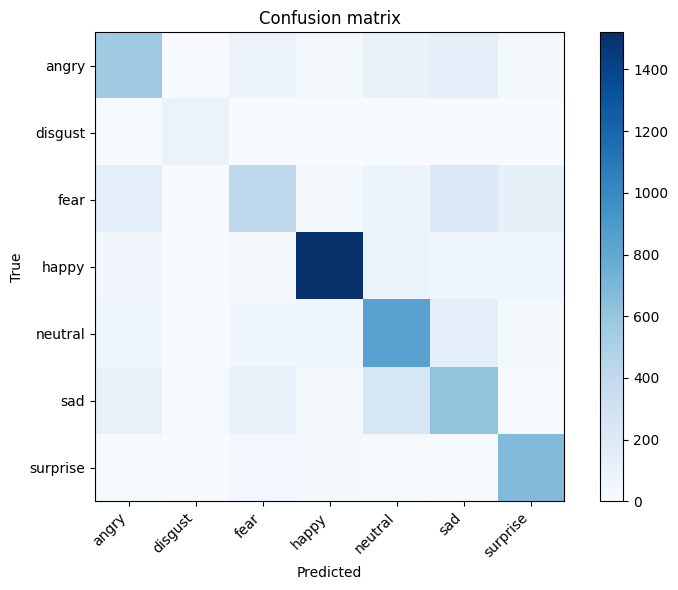

In [6]:
# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(confusion, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [7]:
# Save per-image predictions to CSV
try:
    import pandas as pd
    df = pd.DataFrame({
        'image': [str(p) for p in image_paths],
        'true_label': [class_names[t] for t in y],
        'pred_label': [class_names[p] for p in y_pred],
        'confidence': confidences
    })
    df.to_csv(OUT_CSV, index=False)
    print('Saved predictions to', OUT_CSV)
except Exception:
    # Fallback to csv module if pandas is not available
    import csv
    with open(OUT_CSV, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['image','true_label','pred_label','confidence'])
        for p,t,pr,c in zip(image_paths, y, y_pred, confidences):
            writer.writerow([str(p), class_names[t], class_names[pr], float(c)])
    print('Saved predictions to', OUT_CSV)

Saved predictions to resnet_validation_predictions.csv


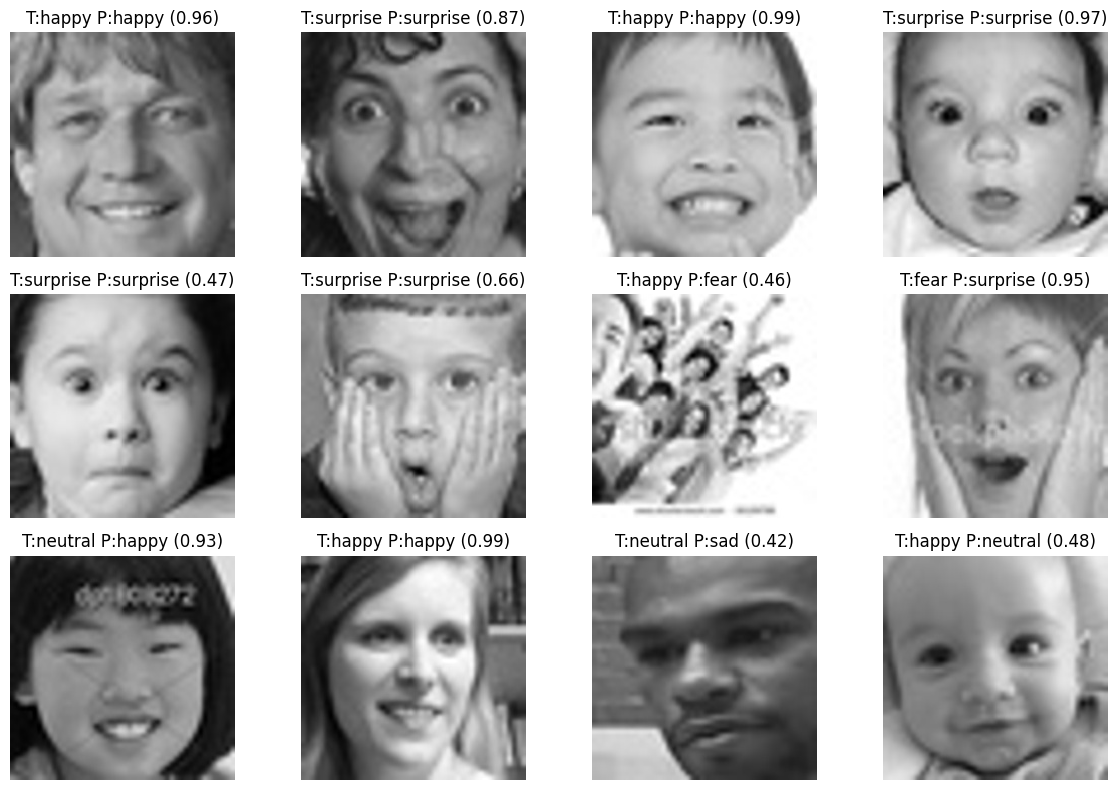

In [12]:
# Display a few examples with predicted and true labels
from IPython.display import display
n_show = min(12, n)
indices = np.random.choice(n, n_show, replace=False)
plt.figure(figsize=(12,8))
for i,idx in enumerate(indices, 1):
    p = image_paths[idx]
    img = cv2.imread(str(p))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None and img.ndim==3 else img
    plt.subplot(3,4,i)
    plt.imshow(img_rgb, interpolation='nearest')
    plt.title(f'T:{class_names[y[idx]]} P:{class_names[y_pred[idx]]} ({confidences[idx]:.2f})')
    plt.axis('off')
plt.tight_layout()
plt.show()